## Adsorption of polymers

* de Gennes self similar carpet

In [1]:
%pylab notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
class monomer:
    ''' monomer class with unique index, containing the coordinates, bondpartners and attributes of a single BFM monomer '''
    def __init__(self, idx_, coords_, attributes_, bonds_ = []):
        ''' setting properties of monomer:
        idx: unique index (int),
        coords: d-dimensional coordinates (np.array),
        attributes: dict of properties (python dict),
        bonds: list of neigbor indizees (np.array)'''
        self.idx = idx_
        self.coords = coords_
        self.attributes = attributes_
        self.bonds = bonds_
#
class validBonds:
    ''' class containing the bondset and utility to check if bonds are valid '''
    def __init__(self):
        self.allBonds = [( 2, 0, 0), (0,  2, 0), (0, 0,  2), # (2,0,0)
                         (-2, 0, 0), (0, -2, 0), (0, 0, -2),
                         (2, 1, 0), (2, 0, 1), (0, 2, 1), (0, 1, 2),(1, 2, 0),(1, 0, 2), # (2,1,0)
                         (-2, 1, 0), (-2, 0, 1), (0, -2, 1), (0, 1, -2),(1, -2, 0),(1, 0, -2),
                         (2, -1, 0), (2, 0, -1), (0, 2, -1), (0, -1, 2),(-1, 2, 0),(-1, 0, 2),
                         (-2, -1, 0), (-2, 0, -1), (0, -2, -1), (0, -1, -2),(-1, -2, 0),(-1, 0, -2),
                         ( 2, 1, 1), (1,  2, 1), (1, 1,  2), # (2,1,1)
                         ( -2, 1, 1), (-1,  2, 1), (-1, 1,  2),
                         ( 2, -1, 1), (1,  -2, 1), (1, -1,  2),
                         ( 2, 1, -1), (1,  2, -1), (1, 1,  -2),
                         ( -2, -1, 1), (-1,  -2, 1), (-1, -1,  2),
                         ( 2, -1, -1), (1,  -2, -1), (1, -1,  -2),
                         ( -2, 1, -1), (-1,  2, -1), (-1, 1,  -2),
                         ( -2, -1, -1), (-1,  -2, -1), (-1, -1,  -2),
                         (2, 2, 1), (2, 1, 2), (1, 2, 2), # (2,2,1)
                         (-2, 2, 1), (-2, 1, 2), (-1, 2, 2),
                         (2, -2, 1), (2, -1, 2), (1, -2, 2),
                         (2, 2, -1), (2, 1, -2), (1, 2, -2),
                         (-2, -2, 1), (-2, -1, 2), (-1, -2, 2),
                         (2, -2, -1), (2, -1, -2), (1, -2, -2),
                         (-2, 2, -1), (-2, 1, -2), (-1, 2, -2),
                         (-2, -2, -1), (-2, -1, -2), (-1, -2, -2),
                         ( 3, 0, 0), (0,  3, 0), (0, 0,  3), # (3,0,0)
                         (-3, 0, 0), (0, -3, 0), (0, 0, -3),
                         (3, 1, 0), (3, 0, 1), (0, 3, 1), (0, 1, 3),(1, 3, 0),(1, 0, 3), # (3,1,0)
                         (-3, 1, 0), (-3, 0, 1), (0, -3, 1), (0, 1, -3),(1, -3, 0),(1, 0, -3),
                         (3, -1, 0), (3, 0, -1), (0, 3, -1), (0, -1, 3),(-1, 3, 0),(-1, 0, 3),
                         (-3, -1, 0), (-3, 0, -1), (0, -3, -1), (0, -1, -3),(-1, -3, 0),(-1, 0, -3)
                        ]
        self.lookup = np.zeros((512))
        # setup lookup table without check
        for b in self.allBonds:
            idf = self.bondToIdentifier(b)
            self.lookup[idf]=1
        
    def bondToIdentifier(self, b):
        ''' return a unique hash for every bond to use the fast lookup table self.lookup '''
        return (b[0] & 7) + ((b[1] &7) << 3) + ((b[2] &7) << 6)
    
    def checkBondInSet(self, b):
        ''' return True if bond b is part of the valid bondset or False otherwise '''
        return self.lookup[(self.bondToIdentifier(b))]
    
#

class excludedVolumeLattice:
    ''' class providing a lookup lattice to implement excluded volume checks in BFM simulations '''
    def __init__(self, box_):
        ''' setup of zero valued lattice with sizes taken from the box'''
        self.boxX, self.boxY, self.boxZ = box_
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        
    def fold_back(self,x,y,z):
        ''' fold back function to account for periodic boundary conditions '''
        myX = (((x% self.boxX)+ self.boxX)% self.boxX)
        myY = (((y% self.boxY)+ self.boxY)% self.boxY)
        myZ = (((z% self.boxZ)+ self.boxZ)% self.boxZ)

        return myX, myY, myZ
    
    def setMonomer(self, x,y,z):
        ''' set the position of a monomer on the lattice '''
        self.lattice[self.fold_back(x  ,y  ,z  )] = 1
        self.lattice[self.fold_back(x+1,y  ,z  )] = 1
        self.lattice[self.fold_back(x  ,y+1,z  )] = 1
        self.lattice[self.fold_back(x  ,y  ,z+1)] = 1
        self.lattice[self.fold_back(x+1,y+1,z  )] = 1
        self.lattice[self.fold_back(x+1,y  ,z+1)] = 1
        self.lattice[self.fold_back(x  ,y+1,z+1)] = 1
        self.lattice[self.fold_back(x+1,y+1,z+1)] = 1

        return True
        
    def clearMonomer(self, x, y, z):
        ''' remove the previous position of a monomer on the lattice  '''
        self.lattice[self.fold_back(x  ,y  ,z  )] = 0
        self.lattice[self.fold_back(x+1,y  ,z  )] = 0
        self.lattice[self.fold_back(x  ,y+1,z  )] = 0
        self.lattice[self.fold_back(x  ,y  ,z+1)] = 0
        self.lattice[self.fold_back(x+1,y+1,z  )] = 0
        self.lattice[self.fold_back(x+1,y  ,z+1)] = 0
        self.lattice[self.fold_back(x  ,y+1,z+1)] = 0
        self.lattice[self.fold_back(x+1,y+1,z+1)] = 0

        return True
    
    def checkIfPosIsEmpty(self,pos):
        x,y,z = pos
        ''' check if monomer position is free on the lattice '''
        if( (self.lattice[self.fold_back(x  ,y  ,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z  )]
          + self.lattice[self.fold_back(x  ,y+1,z  )]
          + self.lattice[self.fold_back(x  ,y  ,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z  )]
          + self.lattice[self.fold_back(x+1,y  ,z+1)]
          + self.lattice[self.fold_back(x  ,y+1,z+1)]
          + self.lattice[self.fold_back(x+1,y+1,z+1)])
           != 0
          ):
            return False
        else:
            return True
        
        
    def syncLattice(self,molecules):
        ''' set lattice to zero again and apply the current lattice occupation from molecules '''
        # reset lattice
        self.lattice = np.zeros((self.boxX,self.boxY,self.boxZ), dtype=np.uint8)
        # refresh lattice occupation
        for m in molecules:
            self.setMonomer(m.coords[0],m.coords[1],m.coords[2])
        
    def checkLattice(self,newPos,move):
        ''' check if a new position of a BFM unit is free on the lattice
        by taking the coordinates of the new anchor and the move coordinates '''
        # shift position by one if move in positive direction to keep the cube
        refPos = 1*newPos
        if ( np.any((np.array(move) > 0)) ):
            refPos += move
            
        # get perpendicular directions to move direction
        #(1 0 0) or (0 1 0)
        perX1 = 1 if move[0]==0 else 0
        perY1 = 1 if move[0]!=0 else 0
        # (0 1 0) or (0 0 1)
        perY2 = 0 if move[2]==0 else 1
        perZ2 = 0 if move[2]!=0 else 1
        #print(move,(perX1,perY1,0),(0,perY2,perZ2))
        
        # check if lattice sites are free
        if(self.lattice[self.fold_back(refPos[0],refPos[1],refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1,refPos[2])] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0],refPos[1]+perY2,refPos[2]+perZ2)] == 1):
            return False
        if(self.lattice[self.fold_back(refPos[0]+perX1,refPos[1]+perY1+perY2,refPos[2]+perZ2)] == 1):
            return False
        
        # if they are free return true
        return True
    
    def moveOnLattice(self,oldPos,newPos):
        ''' update lattice by move: simply delete the old lattice sites and occupy the new ones '''
        self.clearMonomer(oldPos[0],oldPos[1],oldPos[2])
        self.setMonomer(newPos[0],newPos[1],newPos[2])
        return True
        
#        
class adsorption:
    ''' class providing the wall adsorption check function '''
    def __init__(self, delta_, box_, periodicity_):
        ''' setup adsorption energy, probability multiplicator and utility '''
        self.delta = delta_
        self.probabilityMultiplicator = np.exp(-self.delta)
        self.boxX, self.boxY, self.boxZ = box_
        self.pX, self.pY, self.pZ = periodicity_
        
       
    def checkAdsorption(self, oldPos, newPos):
        ''' apply the metropolis algorithm on monomers being adosbed at the wall '''
        oldX, oldY, oldZ = oldPos
        x, y, z = newPos
        
        totalProb = 1.0
        # check adsorption energy: 
        if not self.pX:
            # monomer approaches the wall: 
            if (x == 0 and oldX == 1) or (x == (self.boxX-2) and oldX == (self.boxX-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
            # monomer detaches from the wall 
            elif (x == 1 and oldX == 0) or (x == (self.boxX-3) and oldX == (self.boxX-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                
        if not self.pY:
            # monomer approaches the wall: 
            if (y == 0 and oldY == 1) or (y == (self.boxY-2) and oldY == (self.boxY-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
            # monomer detaches from the wall 
            elif (y == 1 and oldY == 0) or (y == (self.boxY-3) and oldY == (self.boxY-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                
        if not self.pZ:
            # monomer approaches the wall: 
            if (z == 0 and oldZ == 1) or (z == (self.boxZ-2) and oldZ == (self.boxZ-3)):
                # increase move probability if monomer wants to attach the wall
                totalProb /= self.probabilityMultiplicator
            # monomer detaches from the wall 
            elif (z == 1 and oldZ == 0) or (z == (self.boxZ-3) and oldZ == (self.boxZ-2)):
                # reduce move probability if monomer wants to leave the wall
                totalProb *= self.probabilityMultiplicator
                
        # perform metropolis algorithm
        if ( totalProb < 1.0 ):
            if ( random.random() > totalProb ):
                return False
            
        # if not returned false, move might be accepted
        return True
        
class BFMSimulator:
    ''' class providing utilities for 3D BFM simulations:
    monomer container, bondset, move and apply function '''
    def __init__(self, box_, periodicity_, delta_):
        ''' setting up simulation box:
        box = [boxX, boxY, boxZ] (python list of int),
        periodicity = [pX, pY, pZ] (python list of bools), True = is periodic, False = wall
        bondset (instance of class validBonds)
        ... and setup:
        empty molecules as empty list,
        empty lattice (boxX*boxY*boxZ) with 0 as initial value (np.array),
        list of moves (python list)'''
        self.boxX, self.boxY, self.boxZ = box_
        self.pX, self.pY, self.pZ = periodicity_
        self.bondset = validBonds()
        self.molecules = []
        self.lattice = excludedVolumeLattice([self.boxX, self.boxY, self.boxZ])
        self.adsorption = adsorption(delta_, box_, periodicity_)
        self.moves = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
        self.Nmoves = len(self.moves)
        self.setup = False
        
    def connectMonomers(self, idx1, idx2):
        ''' connect two monomers in molecules by index '''
        bond = (self.molecules[idx2].coords - self.molecules[idx1].coords)
        if ( self.bondset.checkBondInSet(bond) ):
            self.molecules[idx1].bonds.append(idx2)
            self.molecules[idx2].bonds.append(idx1)
        else:
            raise ValueError("bond between {} and {} is not valid: {}".format(idx1,idx2, bond))
    
    def checkAddMonomer(self,position):
        ''' boolean check if a new Monomer position is valid (for system creation) '''
        if not self.lattice.checkIfPosIsEmpty(position):
            return False
        # check boundaries: 
        x,y,z = position
        if not self.pX:
            if x < 0 or x > (self.boxX-2):
                return False
        if not self.pY:
            if y < 0 or y > (self.boxY-2):
                return False
        if not self.pZ:
            if z < 0 or z > (self.boxZ-2):
                return False
        # still here? Return True
        return True
    
    def addMonomer(self, coords, attributes):
        ''' add new monomer at the end of molecules '''
        newIdx = len(self.molecules)
        self.lattice.setMonomer(coords[0],coords[1],coords[2])
        self.molecules.append(monomer(newIdx ,coords, attributes,[]))
        
    def plotConfig(self):
        ''' plot all monomers using scatter and bonds using plot with the box as axis boundaries '''
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colorList = ["green","red"]
        
        myX = np.array([x.coords[0] for x in self.molecules])
        myY = np.array([x.coords[1] for x in self.molecules])
        myZ = np.array([x.coords[2] for x in self.molecules])
        
        mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
        for m in self.molecules:
            if (m.idx + 1) in m.bonds:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
            else:
                mX = np.append(mX,myX[m.idx])
                mY = np.append(mY,myY[m.idx])
                mZ = np.append(mZ,myZ[m.idx])
                ax.plot(mX,mY,mZ)
                mX, mY, mZ = [np.array(()),np.array(()),np.array(())]
            
        #ax.plot(myX,myY,myZ)
        
        myFixed = [( x.coords[2]==0 or x.coords[2]==(self.boxZ-2) ) for x in self.molecules]
        myColors = [colorList[int(c)] for c in myFixed ]
        ax.scatter(myX,myY,myZ, c=myColors)
        
        ax.set_xlim3d(0, self.boxX)
        ax.set_ylim3d(0, self.boxY)
        ax.set_zlim3d(0, self.boxZ)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        
        fig.show()
    
    def checkMove(self, idx, direction):
        ''' apply the move checks for monomer with index idx:
        takes monomer id and key of move direction [0,self.Nmoves)
        check the attribute fixed,
        check new bonds, check lattice, check boundaries'''
        # check fixed monomer attribute
        if "fixed" in self.molecules[idx].attributes:
            if (self.molecules[idx].attributes["fixed"] == True):
                return False
            
        # get new position
        newPos = self.molecules[idx].coords + self.moves[direction]
        x, y, z = newPos
        
        # check boundaries: 
        if not self.pX:
            if x == -1 or x == (self.boxX-1):
                return False
        if not self.pY:
            if y == -1 or y == (self.boxY-1):
                return False
        if not self.pZ:
            if z == -1 or z == (self.boxZ-1):
                return False   
        
        # check bonds
        for neighbIdx in self.molecules[idx].bonds:
            bnd = (newPos - self.molecules[neighbIdx].coords)
            if not ( self.bondset.checkBondInSet(bnd) ):
                return False
        
        # check lattice occupation
        if not self.lattice.checkLattice(newPos,self.moves[direction]):
            return False
        
        # check adsorption
        if not self.adsorption.checkAdsorption(self.molecules[idx].coords, newPos):
            return False
        
        # if still here, all checks have been passed
        return True
        
    def applyMove(self,idx,direction):
        ''' apply a move: set new coordinate in molecules and update the lattice '''
        oldPos = 1*self.molecules[idx].coords
        newPos = (self.molecules[idx].coords + self.moves[direction])
        
        if self.lattice.moveOnLattice(oldPos, newPos):
            self.molecules[idx].coords = (newPos)
        else:
            print("error in apply move: Monomer {} in direction {} from {} to {}".format(idx,direction,oldPos,newPos))
        
    def performMCS(self,time, log=False):
        ''' apply the BFM algorithm on a given system for 'time' Monte Carlo sweeps '''
        if self.setup == False:
            self.lattice.syncLattice(self.molecules)
        counter = 0
        mol_size = len(self.molecules)
        for t in range(time):
            for n in range(mol_size):
                randomIdx = random.randint(mol_size)
                randomDir = random.randint(self.Nmoves)
                if self.checkMove(randomIdx,randomDir):
                    self.applyMove(randomIdx,randomDir)
                    counter += 1
            #self.lattice.syncLattice(self.molecules)
        #checkConfig()
        if log:
            print("applied moves / attempted moves:\n{} / {} = {}".format(counter, time*mol_size, counter/(time*mol_size)))
        
    #
    def checkConfig(self):
        ''' sanity check of the full simulation system '''
        nErrors = 0
        for m in self.molecules:
            for bp in m.bonds:
                bv = m.coords - self.molecules[bp].coords
                if self.bondset.checkBondInSet(bv) == False:
                    print("bond between {} and {} not valid: {}".format(m.idx,self.molecules[bp].idx,bv))
                    nErrors += 1
            if not self.pX:
                if (m.coords[0] < 0) or (m.coords[0] > (self.boxX-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pY:
                if (m.coords[1] < 0) or (m.coords[1] > (self.boxY-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
            if not self.pZ:
                if (m.coords[2] < 0) or (m.coords[2] > (self.boxZ-1) ):
                    print("monomer {} violates the simulation box size".format(m.idx))
                    nErrors += 1
                    
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2])))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1],m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0],m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
            if self.lattice.lattice[self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)] == 0:
                print("wrong lattice occupation of monomer {} at {}".format(m.idx,self.lattice.fold_back(m.coords[0]+1,m.coords[1]+1,m.coords[2]+1)))
                nErrors += 1
                
        if self.lattice.lattice.sum() != (len(self.molecules)*8):
            print("total lattice occupation is inconsistent {}/{}".format(self.lattice.lattice.sum(), len(self.molecules)*8))
            nErrors += 1
            
        return nErrors

    
########  utility functions #########

# setup a self avoiding walk
def setupLinearChains(chainLength, numChains, box, periodicity, delta=0.0):
    '''
    create num Chains linear chains of length chainlength in a box of size box(array) with periodicity (array)
    Input: linear chain lenght N ( int ), box size in one dimension ( int )
    Return: instance of BFMSimulator
    '''
    # set delta to zero for system setup
    chainSim = BFMSimulator( box, periodicity, delta)
    steps = [(2,0,0),(0,2,0),(0,0,2),(-2,0,0),(0,-2,0),(0,0,-2)]

    for i in range(numChains):
        for n in range(chainLength):
            if (n > 0):
                cnt = 0
                while cnt < 1000:
                    step = steps[random.randint(len(steps))]
                    coords = chainSim.molecules[-1].coords + step
                    if ( chainSim.checkAddMonomer(coords) ):
                        chainSim.addMonomer(coords,{})
                        chainSim.connectMonomers(len(chainSim.molecules)-2,len(chainSim.molecules)-1)
                        cnt = 1001
                    else:
                        chainSim.performMCS(2)
                        cnt +=1
                if cnt == 1000:
                    raise ValueError("Monomer {} of chain {} could not be placed.".format(n,i))
            else:
                cnt = 0
                while cnt < 100:
                    newChainStart = np.array([random.randint(chainSim.boxX),
                                              random.randint(chainSim.boxY),
                                              random.randint(chainSim.boxZ)])
                    if chainSim.checkAddMonomer(newChainStart):
                        chainSim.addMonomer(newChainStart,{})
                        cnt = 101
                    else:
                        cnt +=1
                        
                if cnt == 100:
                    raise ValueError("First Monomer of chain {} could not be placed.".format(i))
    
    # set delta to values passed to the funtion
    #chainSim.adsorption.delta = delta
    # sanity check before return
    chainSim.checkConfig()
            
    return chainSim


def calculateWallContacts(simulator):
    ''' calcualte the number of monomers at nonperiodic walls and normalize it by the total number of monomers'''
    nContacts = 0
    for mono in simulator.molecules:
        if not simulator.pX:
            if ( mono.coords[0] == 0 or mono.coords[0] == (simulator.boxX-2) ):
                nContacts+=1
        if not simulator.pY:
            if ( mono.coords[1] == 0 or mono.coords[1] == (simulator.boxY-2) ):
                nContacts+=1
        if not simulator.pZ:
            if ( mono.coords[2] == 0 or mono.coords[2] == (simulator.boxZ-2) ):
                nContacts+=1
    return nContacts/len(simulator.molecules)

def separateMolecules(molecules):
    '''
    Find single molecules of successive linear chains
    Input: instance of molecules (list of monomers)
    Return: List of separated molecules (list of lists of monomers)
    '''
    singleMolecule = []
    separatedMolecules = []
    for m in molecules:
        if (m.idx + 1) in m.bonds:
            singleMolecule.append(m)
        else:
            singleMolecule.append(m)
            separatedMolecules.append(singleMolecule)
            singleMolecule = []
    
    return separatedMolecules

def calcRg2(bfmSimulator):
    ''' 
    Sort all monomers to single molecules and calculate Rg componentes in x,y,z for each of them
    Input: instance of BFMSimulator
    Return: List of np.arrays of Rg vectors, one for each (linear) molecule
    '''
    sepMol = separateMolecules(bfmSimulator.molecules)
            
    Rg2All = []
    for mol in sepMol:
        # calculate center of mass
        centerOfMass = np.zeros((3))
        for mono in mol:
            centerOfMass += mono.coords
        centerOfMass /= len(mol)
        
        # get mean squared distances to center of mass
        Rg2 = np.zeros((3))
        for mono in mol:
            diff = mono.coords - centerOfMass
            Rg2 += (diff*diff)
        Rg2 /= len(mol)
        Rg2All.append(Rg2)
        
    return Rg2All

def calculateDensityProfile(simulator):
    ''' 
    Calculate the density profile along the z-direction 
    and returns a numpy array of length boxZ to make averaging simple.
    The density is normalized to one
    '''
    phiOfZ = np.zeros((simulator.boxZ))
    for m in simulator.molecules:
        phiOfZ[m.coords[2]]+=1
        
    return phiOfZ/np.sum(phiOfZ)

# Single chain in strong adsorption

applied moves / attempted moves:
14588 / 64000 = 0.2279375


<IPython.core.display.Javascript object>


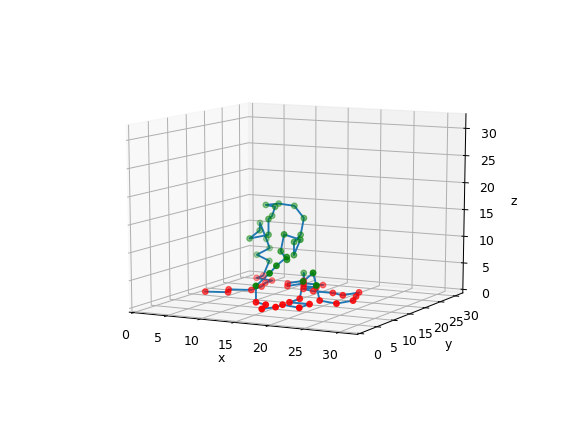

In [4]:
# setup single chain in strong adsorption

# parameters of the chain
chainlength_ = 64
numChains_ = 1
delta_ = 10.0

# parameters of the box
box = [32,32,32]
per = [True, True, False]

''' ---------------------------------------------------------------------- '''
# create chain
singleChainSim = setupLinearChains(chainlength_, numChains_, box, per, delta_)
# equilibrate
singleChainSim.performMCS(1000,True)
#look at config
singleChainSim.plotConfig()

applied moves / attempted moves:
12171 / 64000 = 0.190171875


<IPython.core.display.Javascript object>


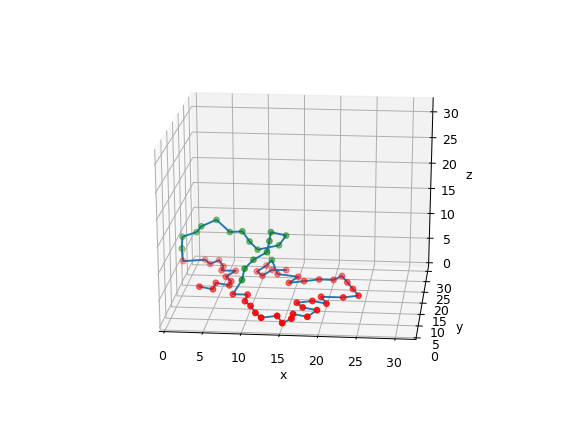

adsorption energy: 10.0, wall contact fraction: 0.71875, radius of gyration: [6.63553113 7.76810825 2.73789951]


In [6]:
# equilibrate
singleChainSim.performMCS(1000,True)
#look at config
singleChainSim.plotConfig()
print("adsorption energy: {}, wall contact fraction: {}, radius of gyration: {}".format(
    singleChainSim.adsorption.delta,
    calculateWallContacts(singleChainSim),
    np.sqrt(np.array(calcRg2(singleChainSim)[0])))
     )

In [7]:
# simulate strongly adsorbed single chain

n_iter = 200
n_timePerIter = 1000

adsorbedMonoFraction = []
Rg2 = []

for n in range(n_iter):
    singleChainSim.performMCS(n_timePerIter)
    adsorbedMonoFraction.append(calculateWallContacts(singleChainSim))
    Rg2.append(np.array(calcRg2(singleChainSim)[0]))
    if n%50 == 0:
        print("n = {}, N_asd/N = {}, Rg_xyz = {}".format(
            n,
            calculateWallContacts(singleChainSim),
            np.sqrt(np.array(calcRg2(singleChainSim)[0])))
             )
    

print("mean fraction of adsorbed monomers: {}\nmean Radius of gyration components: {}".format(adsorbedMonoFraction[-1], Rg2[-1]))

n = 0, N_asd/N = 0.828125, Rg_xyz = [6.53117524 8.33268227 1.30952043]
n = 50, N_asd/N = 0.96875, Rg_xyz = [6.19215418 8.57867997 0.34798527]
n = 100, N_asd/N = 0.96875, Rg_xyz = [6.86133229 8.67072064 0.34798527]
n = 150, N_asd/N = 0.96875, Rg_xyz = [6.5298107  7.62101266 0.34798527]
mean fraction of adsorbed monomers: 0.96875
mean Radius of gyration components: [40.65234375 58.19897461  0.12109375]


<IPython.core.display.Javascript object>


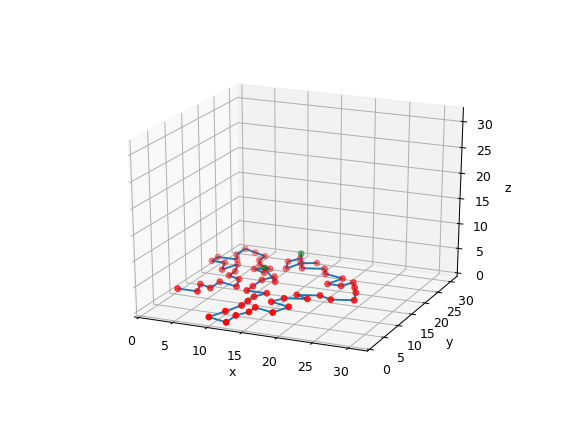

In [23]:
singleChainSim.plotConfig()

<IPython.core.display.Javascript object>


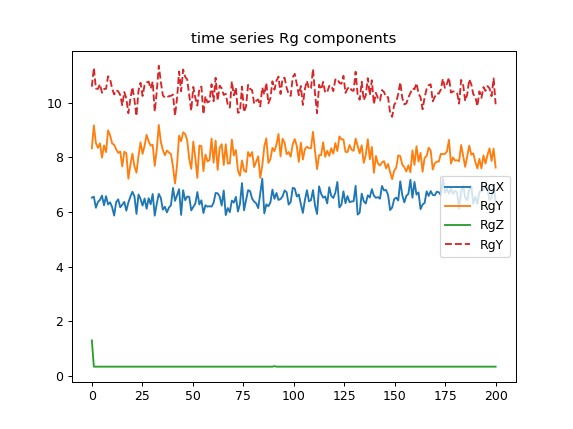

In [16]:
figure()
plot(np.linspace(0,len(Rg2),len(Rg2)),np.sqrt(np.array(Rg2)[:,0]), label="RgX")
plot(np.linspace(0,len(Rg2),len(Rg2)),np.sqrt(np.array(Rg2)[:,1]), label="RgY")
plot(np.linspace(0,len(Rg2),len(Rg2)),np.sqrt(np.array(Rg2)[:,2]), label="RgZ")
plot(np.linspace(0,len(Rg2),len(Rg2)),np.sqrt(np.a6rray(Rg2)[:,0]+np.array(Rg2)[:,1]), "--", label="RgY")
title("time series Rg components")
legend(loc="center right")
show()

In [24]:
''' Do the same for different chain lengths and store results separately to confirm self avoiding walk power law of $R_{gxy} \sim N^x$'''
#rgStore = np.zeros((6,2))
#rgStore[0,:]=np.array([64,np.sum(np.sqrt(np.array(Rg2)[:,0]+np.array(Rg2)[:,1]))/len(Rg2)])
print(rgStore)

[[64.         10.40017329]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


# Adsorption of polymer chain solution in weak adsorption
## de Gennes self similar carpet

density profile along the z direction should decrease with a power law:

$\phi(z) \sim (z/b)^{-(3\nu -1)/\nu} \approx (z/b)^{-4/3}$

In [26]:
def deGennesCarpet(z,b,a):
    return (z/b)**a

## Remarks on the self similar Carpet
* The simple power law is not valid starting directly at the wall, because it does not consider the entropy loss of the polymer chain close to the wall that is an additional repulsive interaction yielding a maximum in $\phi(z)$ close to the wall but not directly at the wall.
* The box parameters, the linear chain length and the volume fraction have to be chosen very carefully to find the carpet (in a finite simulation time)

N = 128, nChain = 19, numMonos = 2432
applied moves / attempted moves:
62113 / 243200 = 0.25539884868421053


<IPython.core.display.Javascript object>


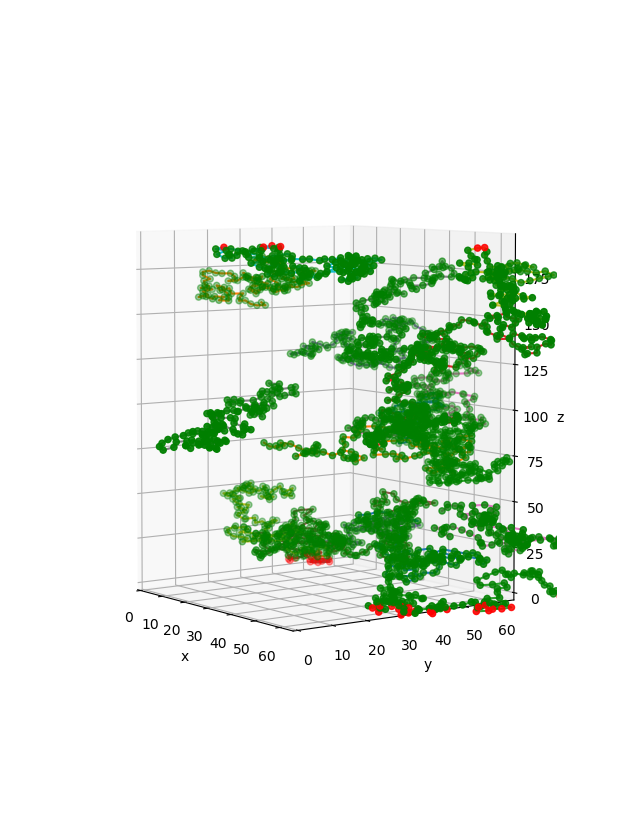

\delta = 1.0. t = 100 -> Nads/N = 0.017269736842105265


In [28]:
# parameters of the chain
chainlength_ = 128
volumeFraction = 0.025
delta = 1.0
myTime = 500

# parameters of the box
box = [64,64,192]
per = [True, True, False]

''' ---------------------------------------------------------------------- '''
# not perfectly sure about the excessible volume of the lattice,
# but as we need to round the values to integers anyway, this seems to be fine
boxVolume = np.prod([box[i]-(2*int(not a)) for i, a in enumerate(per)])
numChains_ = int( (volumeFraction* boxVolume) / (8*chainlength_) )
print("N = {}, nChain = {}, numMonos = {}".format(chainlength_, numChains_, numChains_*chainlength_))

myChainSim = setupLinearChains(chainlength_, numChains_, box, per, delta)
myTime = 100
myChainSim.performMCS(myTime,True)
myChainSim.plotConfig()
print(r"\delta = {}. t = {} -> Nads/N = {}".format(
    myChainSim.adsorption.delta,
    myTime,
    calculateWallContacts(myChainSim))
     )

# setup density profile
phiVonZ = calculateDensityProfile(myChainSim)
meanPhiVonZ = np.zeros(phiVonZ.size)
counter = 0

density profiles after 1000 mcs


<IPython.core.display.Javascript object>


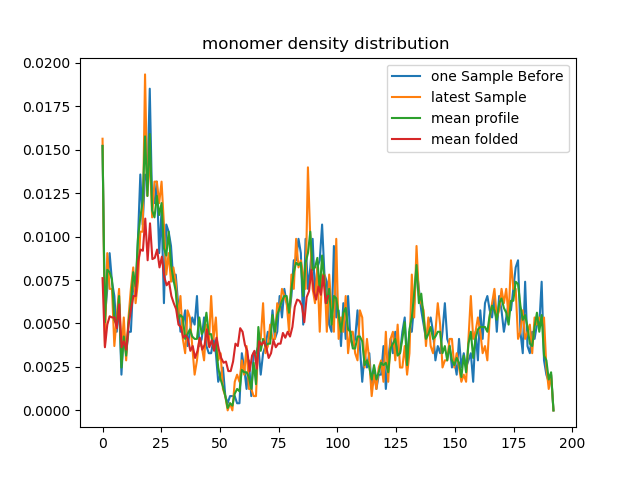

In [35]:
# swap old and updated profile to visualize development
oldphi = np.copy(phiVonZ)
phiVonZ = calculateDensityProfile(myChainSim)

# update the mean profile
print("density profiles after {} mcs".format(counter*myTime))
counter+=1
meanPhiVonZ += phiVonZ

# fold the mean profile
foldedPhiOfZ = (meanPhiVonZ[0:int(meanPhiVonZ.size/2)]+np.flip(meanPhiVonZ[int(meanPhiVonZ.size/2):]) )/2

# plot the profiles
figure()
plot(np.linspace(0,oldphi.size,oldphi.size),oldphi, label="one Sample Before")
plot(np.linspace(0,phiVonZ.size,phiVonZ.size),phiVonZ, label="latest Sample")
plot(np.linspace(0,meanPhiVonZ.size,meanPhiVonZ.size),meanPhiVonZ/counter, label="mean profile")
plot(np.linspace(0,foldedPhiOfZ.size,foldedPhiOfZ.size),foldedPhiOfZ/counter, label="mean folded")
legend(loc="best")
title("monomer density distribution ")
show()

applied moves / attempted moves:
308788 / 1216000 = 0.2539375


<IPython.core.display.Javascript object>


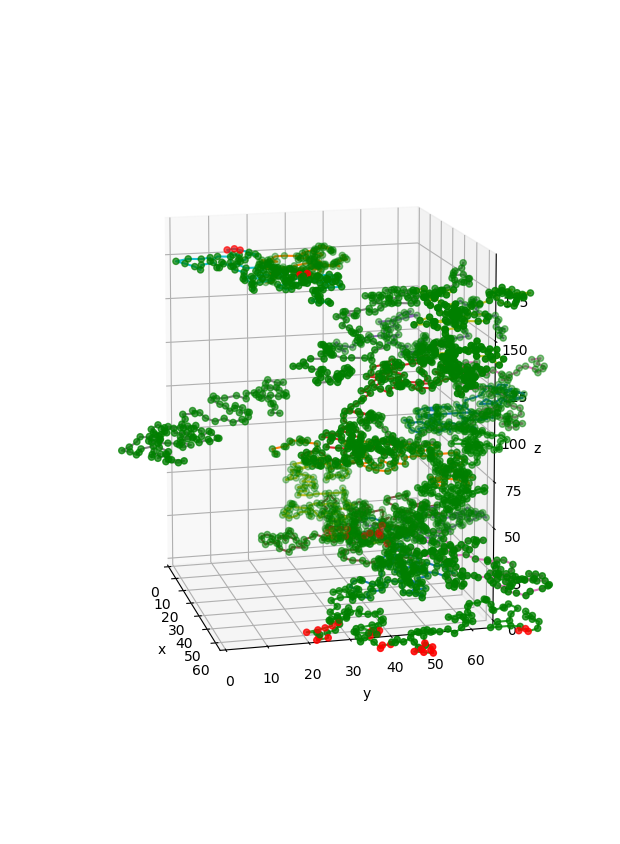

$\delta$ = 1.0. t = 1000 -> Nads/N = 0.01768092105263158


In [34]:
# run the simulation stepwise and evaluation on myChainSim set up above!
myChainSim.performMCS(myTime,True)
myChainSim.plotConfig()
print(r"$\delta$ = {}. t = {} -> Nads/N = {}".format(
    myChainSim.adsorption.delta,
    myTime*counter,
    calculateWallContacts(myChainSim))
     )

In [121]:
# Sometimes save the profile
data = np.vstack((np.linspace(0,meanPhiVonZ.size,meanPhiVonZ.size),meanPhiVonZ)).transpose()
np.savetxt("adsorptionChainSolution_n128_phi01_bxy44_bz128.dat",data)

<IPython.core.display.Javascript object>


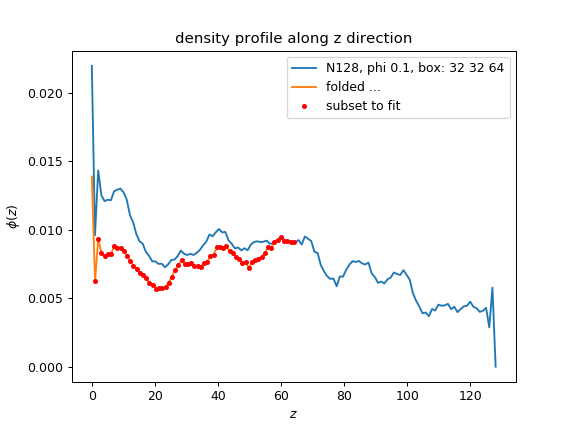

In [29]:
myTime = 500